In [1]:
import sys
import torch

C:\Users\marti\anaconda3\envs\yolo_cnn_deploy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!pip install --upgrade setuptools pip --user
!pip install onnx

!pip install protobuf<4.21.3
!pip install onnxruntime-gpu
!pip install onnx>=1.9.0
!pip install onnx-simplifier>=0.3.6 --user

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


系統找不到指定的檔案。


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
!python export.py --weights weight/tiny/best.pt \
        --grid --end2end --simplify \
        --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 \
        --img-size 640 640 --max-wh 640

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(batch_size=1, conf_thres=0.35, device='cpu', dynamic=False, dynamic_batch=False, end2end=True, fp16=False, grid=True, img_size=[640, 640], include_nms=False, int8=False, iou_thres=0.65, max_wh=640, simplify=True, topk_all=100, weights='weight/tiny/best.pt')
Fusing layers... 
IDetect.fuse

Starting TorchScript export with torch 1.12.1+cu116...
TorchScript export success, saved as weight/tiny/best.torchscript.pt
CoreML export failure: No module named 'coremltools'

Starting TorchScript-Lite export with torch 1.12.1+cu116...
TorchScript-Lite export success, saved as weight/tiny/best.torchscript.ptl

Starting ONNX export with onnx 1.13.0...
onnxruntime

Starting to simplify ONNX...
ONNX export success, saved as weight/tiny/best.onnx

Export complete (10.48s). Visualize with https://github.com/lutzroeder/netron.


YOLOR  v0.1-119-g45f2c1f torch 1.12.1+cu116 CPU

C:\Users\marti\AppData\Roaming\Python\Python38\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 208 layers, 6010302 parameters, 0 gradients, 13.0 GFLOPS
E:\yolo\yolov7_cnn_deploy\models\yolo.py:150: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4]:
C:\Users\marti\AppData\Roaming\Python\Python38\site-packages\torch\onnx\symbolic_opset9.py:4189: UserWarning: Exporting aten

In [3]:
# Inference for ONNX model
import cv2
cuda = True
w = "weight/tiny/best.onnx"
img = cv2.imread('outset2_16200.jpg')

In [4]:
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

# providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
providers = ['CUDAExecutionProvider']
session = ort.InferenceSession(w, providers=providers)


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

names = ['person', 'fall']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

outname = [i.name for i in session.get_outputs()]
outname

inname = [i.name for i in session.get_inputs()]
inname

inp = {inname[0]:im}

In [8]:
# ONNX inference
outputs = session.run(outname, inp)[0]
outputs

array([[0.0000000e+00, 1.1541530e+02, 2.4409120e+02, 1.2787720e+02,
        2.8218405e+02, 0.0000000e+00, 9.2134571e-01],
       [0.0000000e+00, 4.7125613e+02, 2.6113156e+02, 4.8290390e+02,
        2.8483981e+02, 0.0000000e+00, 7.7976781e-01],
       [0.0000000e+00, 4.8249301e+02, 2.6059348e+02, 4.9275143e+02,
        2.8704031e+02, 0.0000000e+00, 7.3141307e-01],
       [0.0000000e+00, 3.4914511e+02, 3.6802426e+02, 4.3376578e+02,
        3.9782138e+02, 1.0000000e+00, 4.3733171e-01],
       [0.0000000e+00, 3.2664783e+02, 3.3337915e+02, 3.9208997e+02,
        3.5309900e+02, 1.0000000e+00, 3.7578583e-01]], dtype=float32)

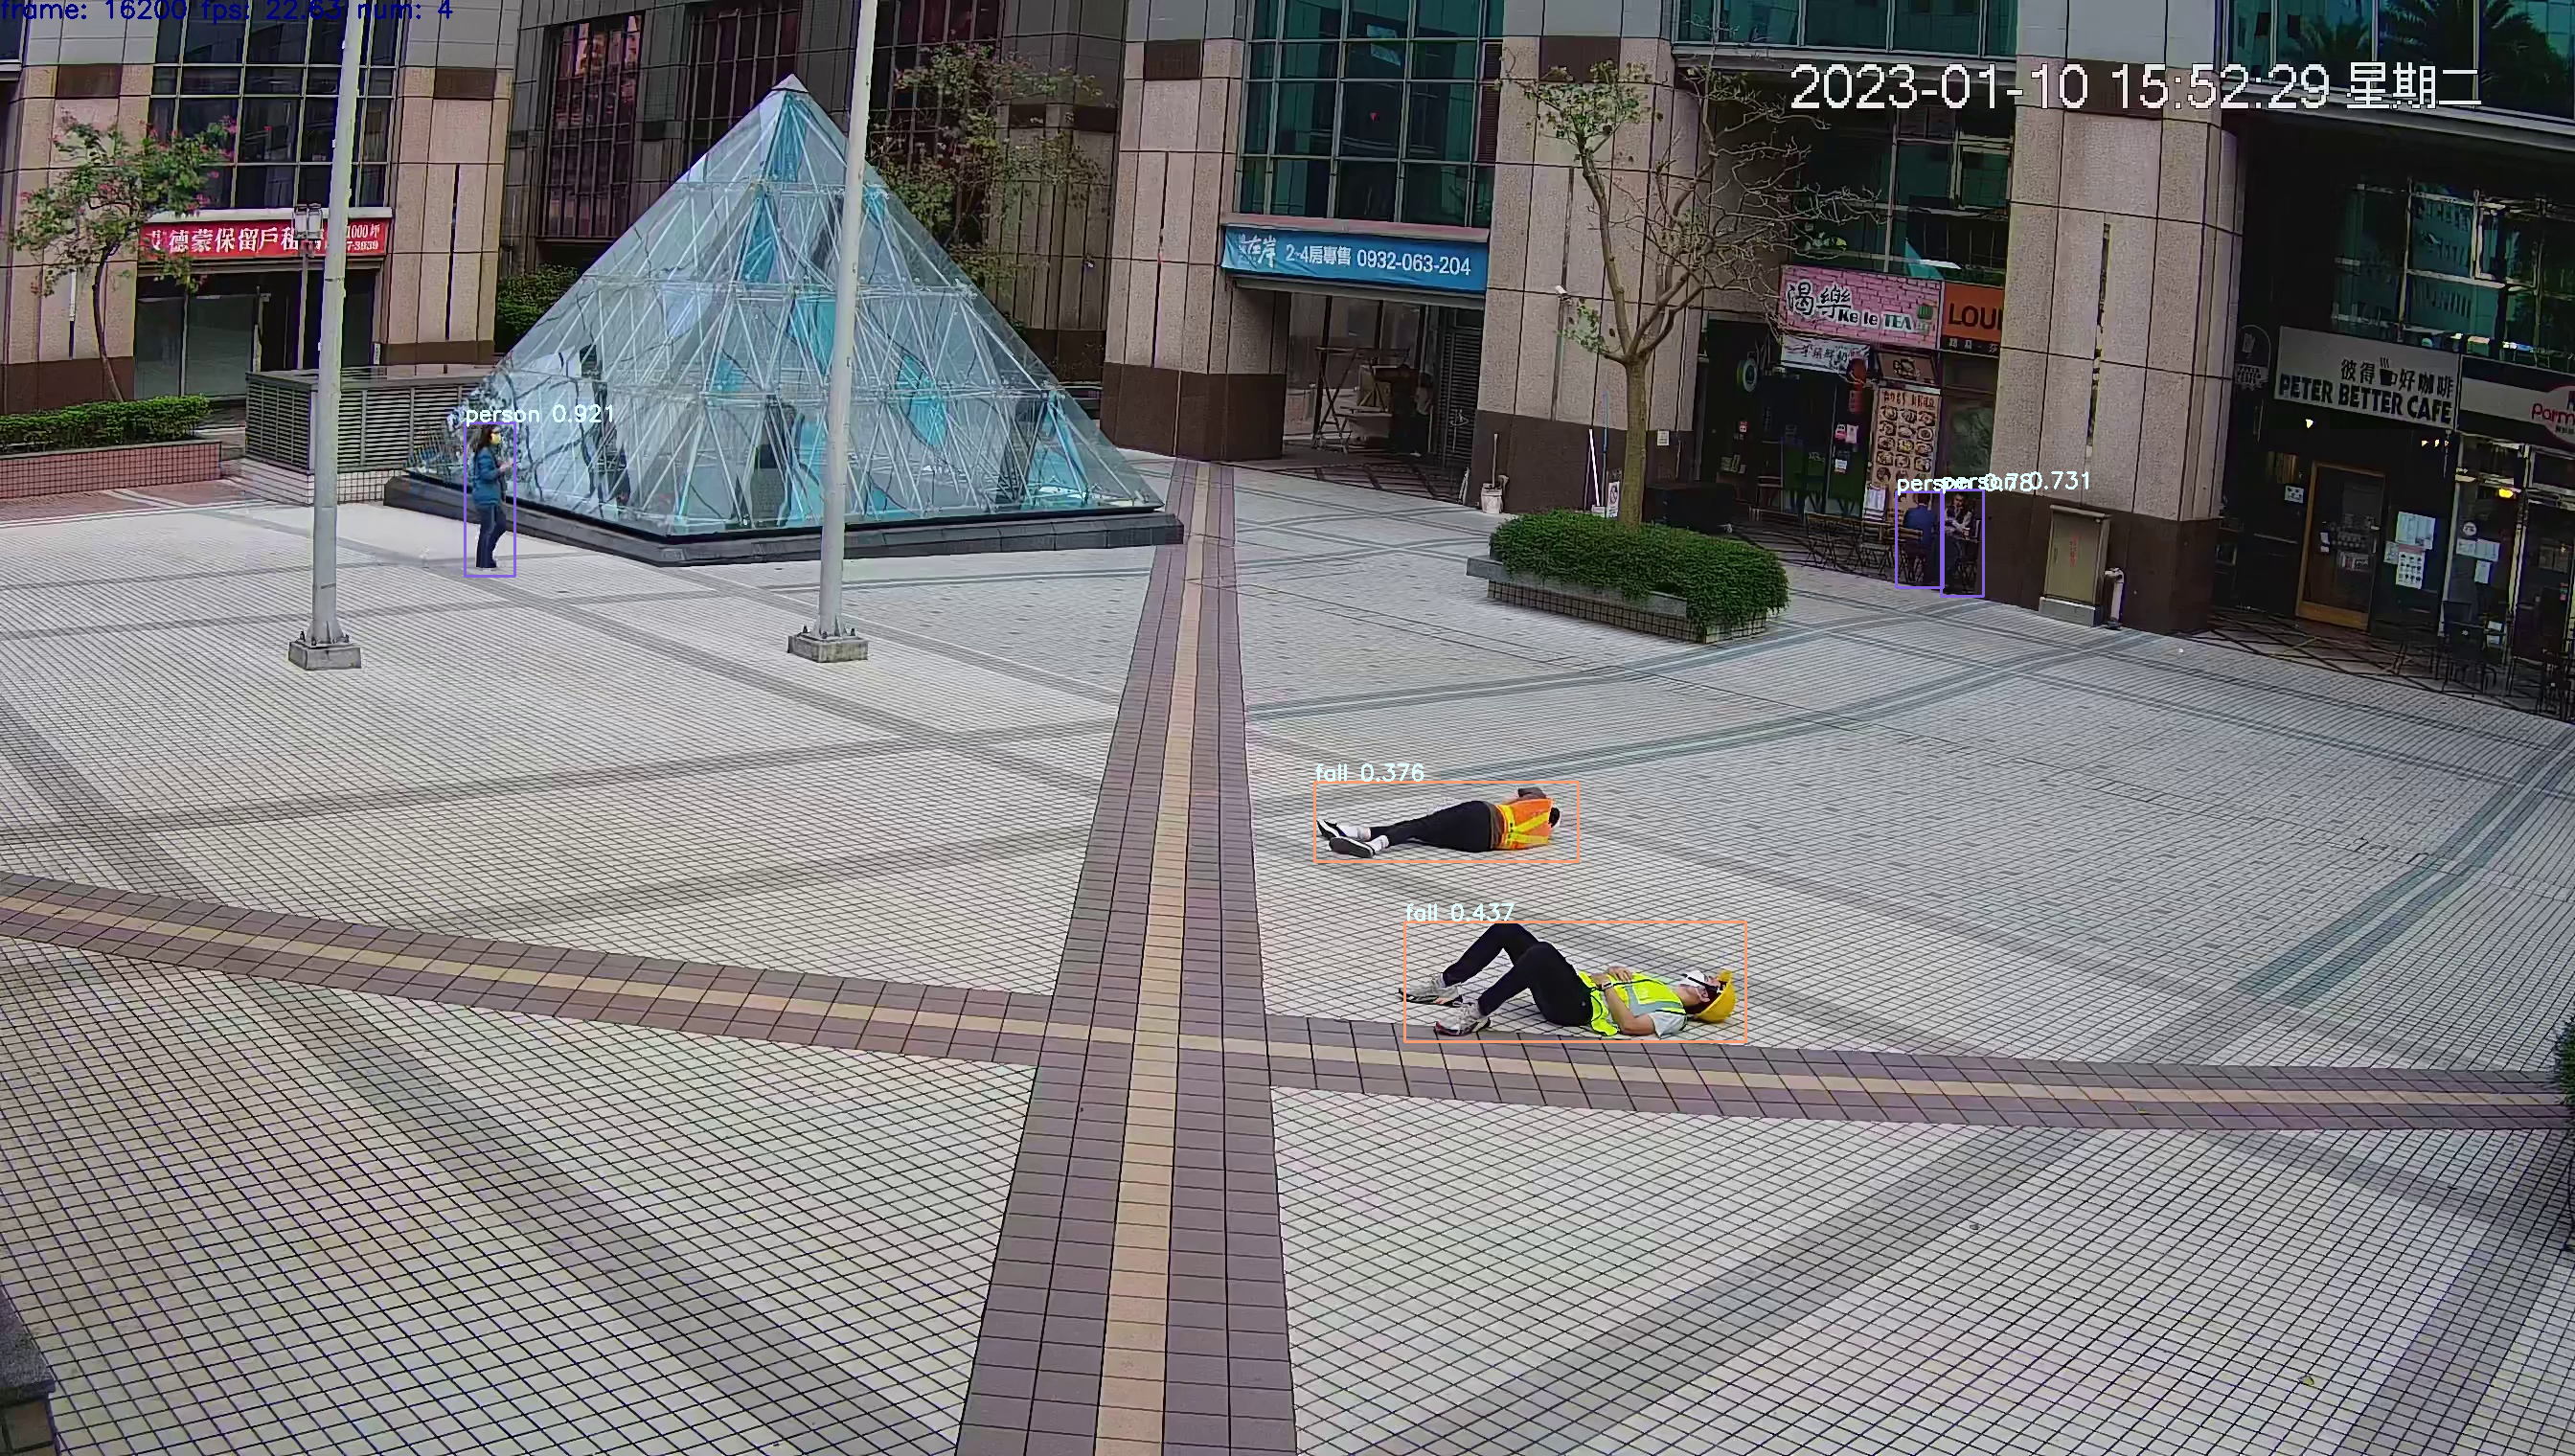

In [6]:
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)

Image.fromarray(ori_images[0])